# Задание 1 (1 балл)

Если разбить поисковые запросы пользователей в РФ по тематикам, то можно выделить несколько кластеров, запросы в которых имеют похожий смысл или тему. В файле `searches.csv` - 6 временных рядов, соответствующих кластерам:

    1. Коронавирус
    2. Отели за границей
    3. Школьные задания
    4. Подарки и поздравления
    5. Спортивные события
    6. Музыка

Определите, какой временной ряд относится к какому кластеру.

Дайте ответ для всех кластеров в формате "кластерX - `<название>`, потому что ... (ваши наблюдения и выводы на основе временного ряда)".

Ответы без обоснования не будут приняты.


In [ ]:
import pandas as pd
from prophet import Prophet

searches_df = pd.read_csv('searches.csv', parse_dates=['ds'])
searches_df.head()

,ds,кластер1,кластер2,кластер3,кластер4,кластер5,кластер6
0,2019-01-01,299036,1493286,11268577,50492,18596,599268
1,2019-01-02,228190,818971,8629779,57169,25282,952299
2,2019-01-03,297875,734393,7828308,61336,25863,1176552
3,2019-01-04,211296,742071,7542338,64927,27730,1304149
4,2019-01-05,270611,828797,7618576,62939,27709,1419539


Давайте поработаем с библиотекой etna и переведем все в TsDataset. Там визуализация удобная)

In [ ]:
!pip install etna

In [ ]:
from etna.datasets import TSDataset

/usr/local/lib/python3.10/dist-packages/etna/settings.py:37: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:45: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:61: UserWarning: `tsfresh` is not available, to install it, run `pip install tsfresh==0.19.0 && pip install protobuf==3.20.1`
  warnings.warn(


In [ ]:
ms = pd.melt(searches_df, id_vars=['ds'], value_vars=['кластер1', 'кластер2', 'кластер3', 'кластер4', 'кластер5', 'кластер6'])
ms.head()

,ds,variable,value
0,2019-01-01,кластер1,299036
1,2019-01-02,кластер1,228190
2,2019-01-03,кластер1,297875
3,2019-01-04,кластер1,211296
4,2019-01-05,кластер1,270611


In [ ]:
ms.rename(columns={"ds": "timestamp", "variable": "segment", "value": "target"}, inplace=True)
tsms = TSDataset.to_dataset(ms)
tsms.head()

segment,кластер1,кластер2,кластер3,кластер4,кластер5,кластер6
feature,target,target,target,target,target,target
timestamp,,,,,,
2019-01-01,299036,1493286,11268577,50492,18596,599268
2019-01-02,228190,818971,8629779,57169,25282,952299
2019-01-03,297875,734393,7828308,61336,25863,1176552
2019-01-04,211296,742071,7542338,64927,27730,1304149
2019-01-05,270611,828797,7618576,62939,27709,1419539


In [ ]:
# то есть измерения происходили каждый день
ts = TSDataset(tsms, freq="D")

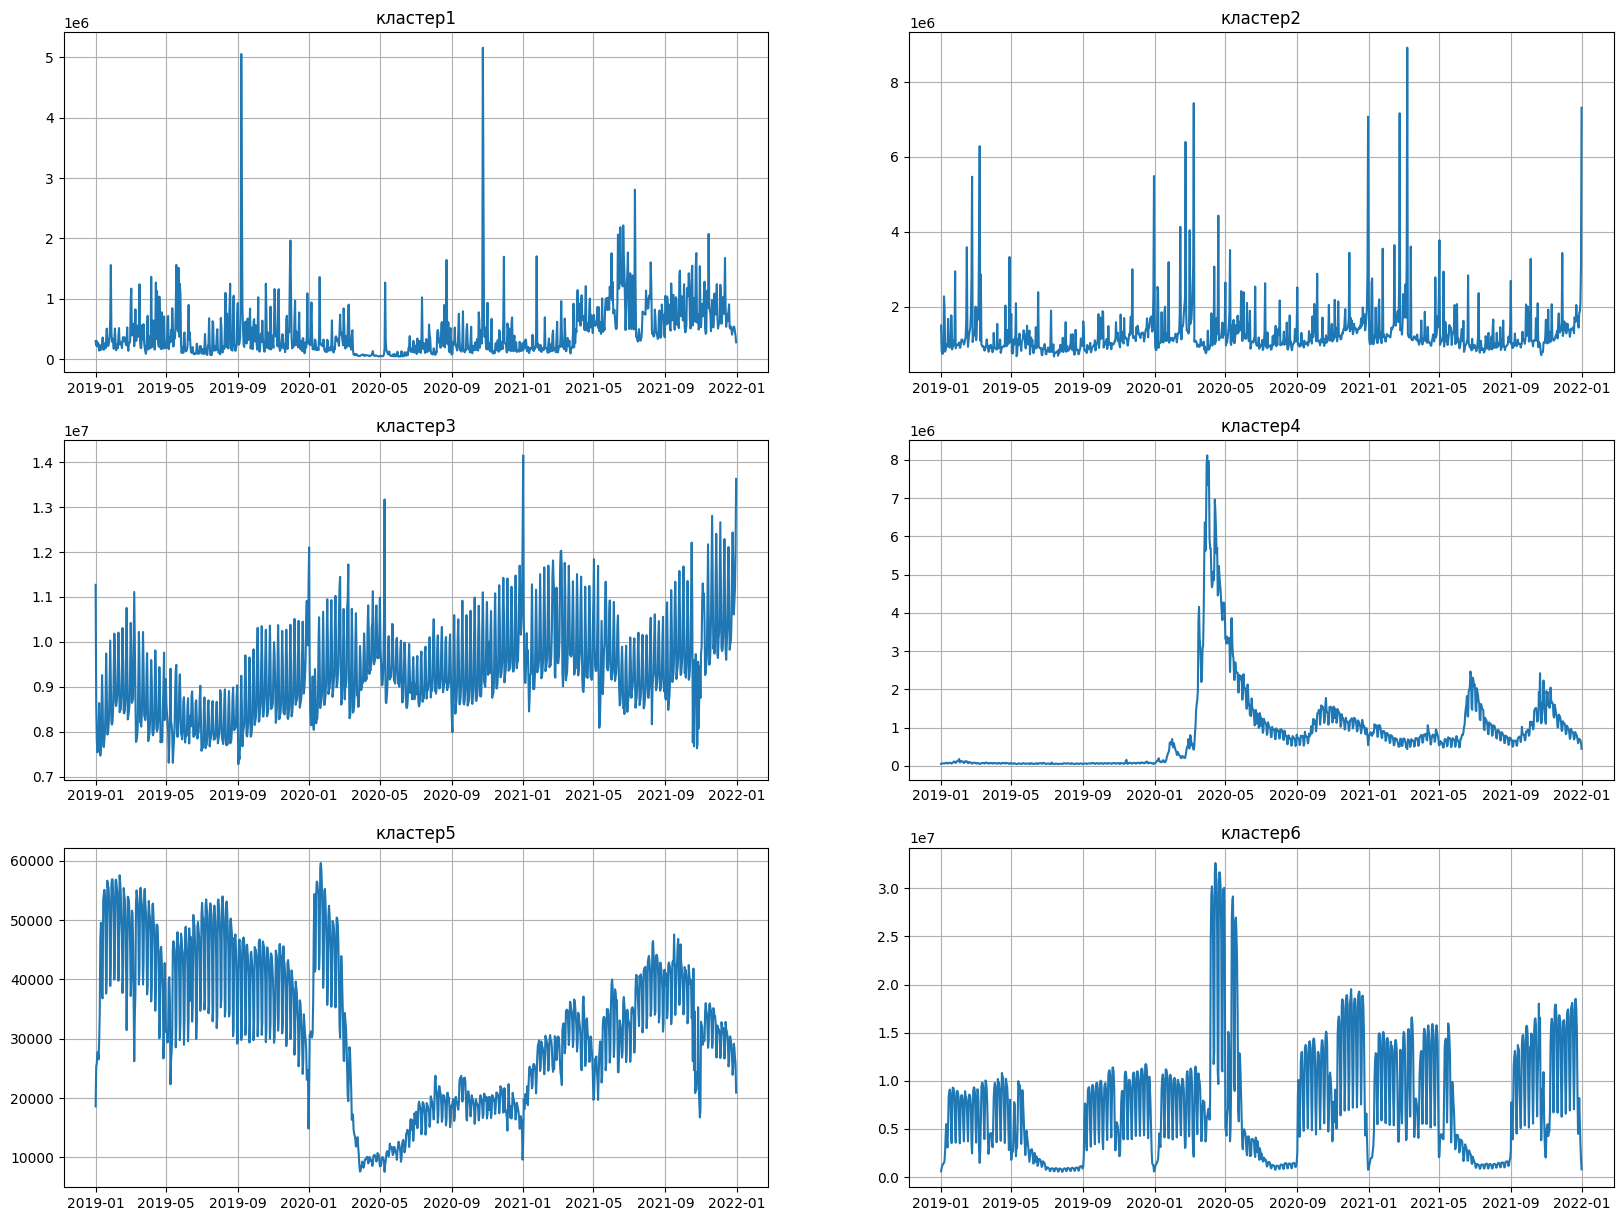

In [ ]:
ts.plot()

- Кластер1 - Отели за границей, так как в период пандемии стали закрывать границы -> наблюдаем сильный спад примерно с марта 2020 года и постепенный рост с июня 2020 (восстанавление туризма)
- Кластер2 - Подарки и поздравления, так как есть ежегодный сильный рост в промежуток с января по май (вероятно это 23 февраля и 8 марта), а таксже скачок около нового года. Это как раз те дни, когда очень многие покупают подарки
- Кластер3 - Музыка. Методом исключения)
- Кластер4 - Коронавирус. 2 марта 2020 года был выявлен первый случай заболевания в Москве, примерно с этого момента наблюдается рост, а в марте - мае он достиг пика (период карантина и нерабочих дней)
- Кластер5 - Спортивные события. В начале 2020 года началась пандемия, поэтому видим падение. В марте было объявлено о переносе летних олимпийских игр и это вероятно вызвало рост. Далее спортивный сезон был закрыт из-за пандемии, поэтому наблюдается резкий спад и дальнейший плавнй рост. Летом 2021 года проходили Олимпийские игры, поэтому наблюдается скачок запросов.
- Кластер6 - Школьные задания, так как наблюдаются значительные падения (близкие к 0) в летний период (каникулы у школьников)

**Mistakes**

Кластер 1  − спортивные события. Всплески во время футбольных и хоккейных матчей, а также UFC .

Кластер 5  − отели за границей. Закрытие границ привело к невозможности куда-либо выехать, а при постепенном ослаблении ограничений интерес к путешествиям появился снова.

# Задание 2 (4 балла)


## Задача

Вам дана небольшая выборка поисковых запросов, связанных с поиском работм. Запросы разбиты на подкатегории 1, 2, 3, 4, 5, 6, 7 и 8.
Вам нужно сделать подневный прогноз **суммы** поисковых запросов с учётом трендов, сезонности, праздников и аномалий. При этом нужно продемонстрировать качество модели.

Представьте, что сегодня 1 июля 2021 года, и вам нужно спрогнозировать количество запросов до конца 2021 года.

Прогноз можно строить в Excel, Jupyter Notebook или другими знакомыми инструментами. Главное, чтобы расчёт мог воспроизвести другой человек.

## Данные



Для того, чтобы не только сделать прогноз, но и проверить качество модели, данные разбиты на три файла:

`train.csv` - обучающая выборка с 2017-01-01 по 2020-12-31

`test.csv` - тестовая выборка с 2021-01-01 по 2021-06-30

`val.csv` - валидационная выборка с 2021-07-01 по 2021-12-31. **Для чистоты эксперимента не смотрите его пока что, это данные о будущем, которое хотим предсказать.**

Их назначение будет объяснено позже.

## Оценка качества

Для оценки качества прогнозных моделей проведём эксперимент: скроем от модели часть известных нам данных, построим прогноз, а затем проверим, насколько хорошо он попадает в факт.

Для оценки качества моделей будем использовать метрику [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) по дням: $\text{MAPE} = 100\% \cdot \dfrac{1}{n}\sum_{i=1}^n  \left|\dfrac{факт_i - прогноз_i}{факт_i}\right| $

Например, если нужно рассчитать MAPE за первые 6 месяцев 2021 года (181 день), получим формулу $\text{MAPE} = 100\% \cdot \dfrac{1}{181}\sum_{i=1}^{181}  \left|\dfrac{факт_i - прогноз_i}{факт_i}\right| $


In [ ]:
# Пример функции MAPE, которая принимает на вход два списка с значениями
def mape(fact_list, forecast_list):
    errors = []

    for f, p in zip(fact_list, forecast_list):
        e = abs((f - p) / f)
        errors.append(e)

    return 100.0 * sum(errors) / len(errors)

mape([1, 2, 3, 4], [0.5, 1.5, 3, 4.5])

21.875

## 2.1. Базовый прогноз (1 балл)
1. Откройте обучающую выборку из файла `train.csv` в Excel или загрузите в pandas DataFrame. Модели должны обучаться только на ней
2. Постройте график временного ряда суммы поисковых запросов
3. Постройте прогноз этого ряда до конца 2021 года любым удобным вам способом (например, взяв код или формулу из лекции) **без** очистки данных, подбора параметров модели, учёта праздников и пр.
4. Прочитайте тестовые данные из файла `test.csv` и посчитайте ошибку прогноза (MAPE) на данных за первое полугодие 2021 года. Назовём это значение ошибки `mape1`

In [ ]:
train_df = pd.read_csv('train.csv', parse_dates=['ds'])
train_df.head()

,ds,1,2,3,4,5,6,7,8
0,2017-01-01,8061,10075,20735,8641,3414,39,2343,11229
1,2017-01-02,13243,15663,33827,18966,5900,61,4213,14216
2,2017-01-03,16230,18959,38730,24648,7560,65,5874,17375
3,2017-01-04,18671,21144,42381,29907,9394,69,8042,19965
4,2017-01-05,20471,23040,43880,32436,10076,72,8731,20599


In [ ]:
# временной ряд суммы всех поисковых запросов (факт)
train_sum_df = pd.DataFrame({'ds': train_df.ds, 'y': list(train_df.iloc[:, 1:].sum(axis=1))})
train_sum_df.head()

,ds,y
0,2017-01-01,64537
1,2017-01-02,106089
2,2017-01-03,129441
3,2017-01-04,149573
4,2017-01-05,159305


<Axes: xlabel='ds'>

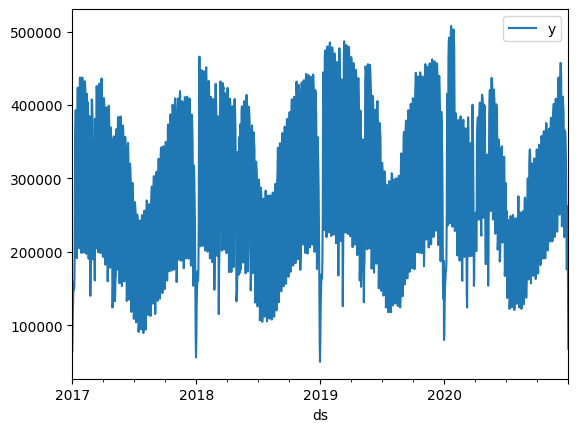

In [ ]:
# постройте график суммарного временного ряда
train_sum_df.plot(x='ds', y='y')

In [ ]:
model = Prophet()
model.fit(train_sum_df)
future_df = model.make_future_dataframe(periods=365, include_history=False)

# постройте прогноз этого суммарного ряда
forecast_df_1 = model.predict(future_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbdd_vhmy/q1adjhl_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbdd_vhmy/tpjisg0w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73376', 'data', 'file=/tmp/tmpbdd_vhmy/q1adjhl_.json', 'init=/tmp/tmpbdd_vhmy/tpjisg0w.json', 'output', 'file=/tmp/tmpbdd_vhmy/prophet_modelvh_q9xn2/prophet_model-20230617175129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#  The forecast object here is a new dataframe that includes a column yhat with the forecast,
# as well as columns for components and uncertainty intervals.

forecast_df_1.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,283746.309459,126251.934920,235744.165972,283746.309459,283746.309459,-99895.178701,-99895.178701,-99895.178701,-7690.126305,-7690.126305,-7690.126305,-92205.052396,-92205.052396,-92205.052396,0.0,0.0,0.0,183851.130758
1,2021-01-02,283673.312509,12315.096109,122988.251087,283673.312509,283673.312509,-216685.363215,-216685.363215,-216685.363215,-126401.446948,-126401.446948,-126401.446948,-90283.916267,-90283.916267,-90283.916267,0.0,0.0,0.0,66987.949294
2,2021-01-03,283600.315560,52874.575512,160723.550564,283600.315560,283600.315560,-177835.607624,-177835.607624,-177835.607624,-90958.269543,-90958.269543,-90958.269543,-86877.338081,-86877.338081,-86877.338081,0.0,0.0,0.0,105764.707936
3,2021-01-04,283527.318610,201983.583899,311106.831074,283527.318610,283527.318610,-28458.469910,-28458.469910,-28458.469910,53564.629156,53564.629156,53564.629156,-82023.099066,-82023.099066,-82023.099066,0.0,0.0,0.0,255068.848700
4,2021-01-05,283454.321661,216277.485675,332641.746164,283454.321661,283454.321661,-10738.990539,-10738.990539,-10738.990539,65045.239291,65045.239291,65045.239291,-75784.229830,-75784.229830,-75784.229830,0.0,0.0,0.0,272715.331121


In [ ]:
test_df = pd.read_csv('test.csv', parse_dates=['ds'])
test_df.head()

,ds,1,2,3,4,5,6,7,8
0,2021-01-01,15721,26737,22323,6795,4608,54,5080,0
1,2021-01-02,22581,42605,33369,14446,7526,77,7141,0
2,2021-01-03,28147,42337,38091,18697,9639,89,8755,0
3,2021-01-04,30981,45813,39446,23713,11766,92,12895,0
4,2021-01-05,33250,45727,41607,25525,12616,96,13744,0


In [ ]:
# сумма всех поисков по дням из тестовой выборки
test_sum_df = pd.DataFrame({'ds': test_df.ds, 'y': list(test_df.iloc[:, 1:].sum(axis=1))})

# посчитайте ошибку

mape1 = mape(test_sum_df.y, forecast_df_1[forecast_df_1.ds <= '2021-06-30'].yhat)
print(f'mape1 = {mape1}')

mape1 = 13.782042914850779


## 2.2. Декомпозиция (1 балл)

Давайте проверим, получится ли модель точнее, если мы спрогнозируем сначала поиски по категориям, а затем суммируем.

5. Посмотрите категории поисковых запросов и определите, стоит ли все временные ряды прогнозировать независимо, или часть из них стоит сгруппировать в более крупные сущности (например, из 8 временных рядов можно получить 4). Почему?
6. Постройте прогнозы по исходным или сгруппированным временным рядам (так же **без** предобработки данных), посчитайте MAPE для суммы всех поисков. Назовём её `mape2`

Задание считается выполненным, если у вас есть прогноз, есть **минимум 2 группы** запросов и вы **объяснили**, почему объединили данные именно так (если объединяли) или почему не стали объединять.

In [ ]:
ms = pd.melt(train_df, id_vars=['ds'], value_vars=['1', '2', '3', '4', '5', '6', '7', '8'])
ms.rename(columns={"ds": "timestamp", "variable": "segment", "value": "target"}, inplace=True)
tsms = TSDataset.to_dataset(ms)
tsms.head()

segment,1,2,3,4,5,6,7,8
feature,target,target,target,target,target,target,target,target
timestamp,,,,,,,,
2017-01-01,8061,10075,20735,8641,3414,39,2343,11229
2017-01-02,13243,15663,33827,18966,5900,61,4213,14216
2017-01-03,16230,18959,38730,24648,7560,65,5874,17375
2017-01-04,18671,21144,42381,29907,9394,69,8042,19965
2017-01-05,20471,23040,43880,32436,10076,72,8731,20599


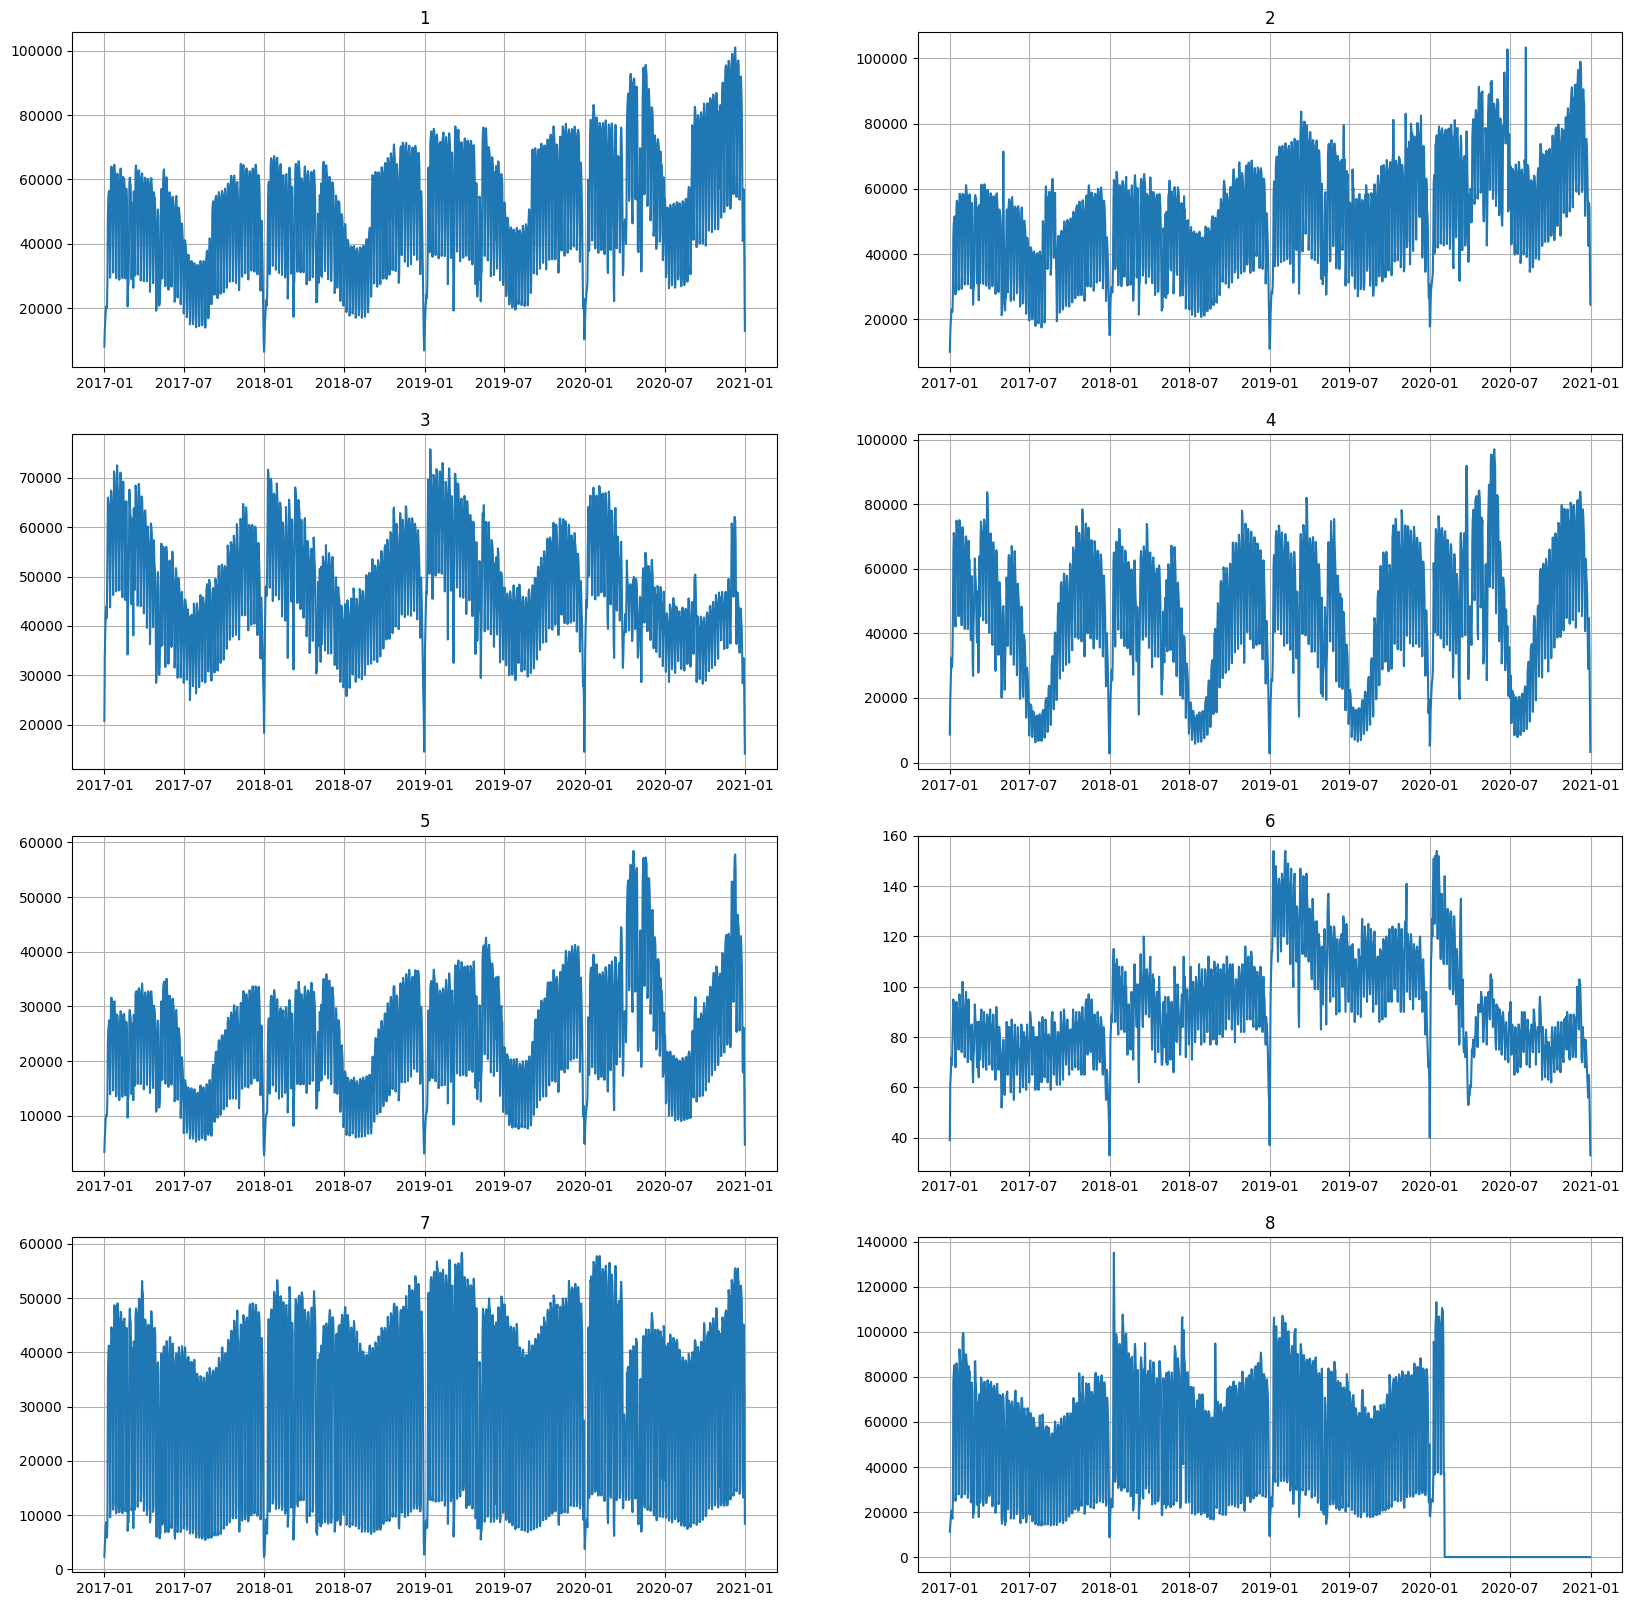

In [ ]:
# то есть измерения происходили каждый день
ts = TSDataset(tsms, freq="D")
ts.plot()

In [ ]:
# сгруппируйте категории запросов, если нужно. Почему именно так?
prep_train_df =  pd.DataFrame({'ds': train_df.ds,
                         '1, 3-5, 7': list(pd.concat([train_df['1'], train_df.iloc[:, 3:6], train_df['7']], axis=1).sum(axis=1)),
                         '2':train_df['2'],
                         '6':train_df['6']})
prep_train_df.head()

,ds,"1, 3-5, 7",2,6
0,2017-01-01,43194,10075,39
1,2017-01-02,76149,15663,61
2,2017-01-03,93042,18959,65
3,2017-01-04,108395,21144,69
4,2017-01-05,115594,23040,72


Объединила 1, 3-5 и 7, так как они сильно схожи по тренду и сезонности (волна каждый седьмой месяц и резкий спад каждый январь). В эту группу можно было еще второй график добавить, но там чет в 17 и в 21 году сильные отличия, поэтому лучше на нем отдельно обучимся

6 рассмотрим отдельно, так как там небольшие цифры и динамика совершенно другая. 8ой просто кикнем, ибо модель улавливает отрицательный тренд и начинает предиктить не то.

In [ ]:
train_df2 = pd.melt(prep_train_df, id_vars='ds', value_vars=['1, 3-5, 7', '2', '6'])
train_df2.columns = ['timestamp', 'segment', 'target']
train_df2.head()

,timestamp,segment,target
0,2017-01-01,"1, 3-5, 7",43194
1,2017-01-02,"1, 3-5, 7",76149
2,2017-01-03,"1, 3-5, 7",93042
3,2017-01-04,"1, 3-5, 7",108395
4,2017-01-05,"1, 3-5, 7",115594


<Axes: xlabel='timestamp', ylabel='target'>

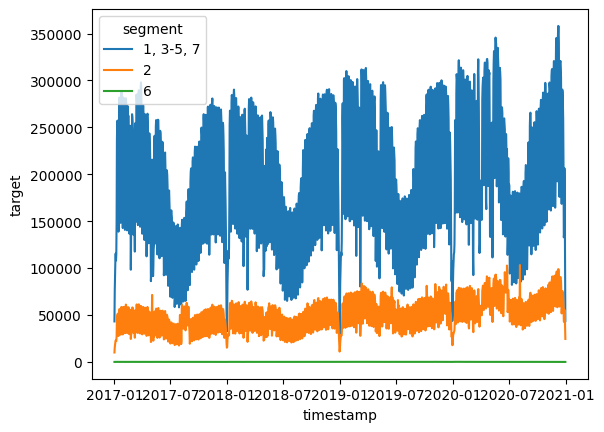

In [ ]:
import seaborn as sns
sns.lineplot(data=train_df2, x="timestamp", y="target", hue="segment")

In [ ]:
# что то я не разобралась как делать мультисегментный предикт, поэтому оберну все в этну (она сама все хорошо сделает)
tsms = TSDataset.to_dataset(train_df2)
ts = TSDataset(tsms, freq="D")
ts.head()

segment,"1, 3-5, 7",2,6
feature,target,target,target
timestamp,,,
2017-01-01,43194,10075,39
2017-01-02,76149,15663,61
2017-01-03,93042,18959,65
2017-01-04,108395,21144,69
2017-01-05,115594,23040,72


In [ ]:
from etna.models import ProphetModel

model = ProphetModel()
model.fit(ts)

future_ts = ts.make_future(365)
forecast_ts = model.forecast(future_ts)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbdd_vhmy/n6f1k1m3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbdd_vhmy/klfgswfy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57714', 'data', 'file=/tmp/tmpbdd_vhmy/n6f1k1m3.json', 'init=/tmp/tmpbdd_vhmy/klfgswfy.json', 'output', 'file=/tmp/tmpbdd_vhmy/prophet_modelid4_li0r/prophet_model-20230617175135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbd

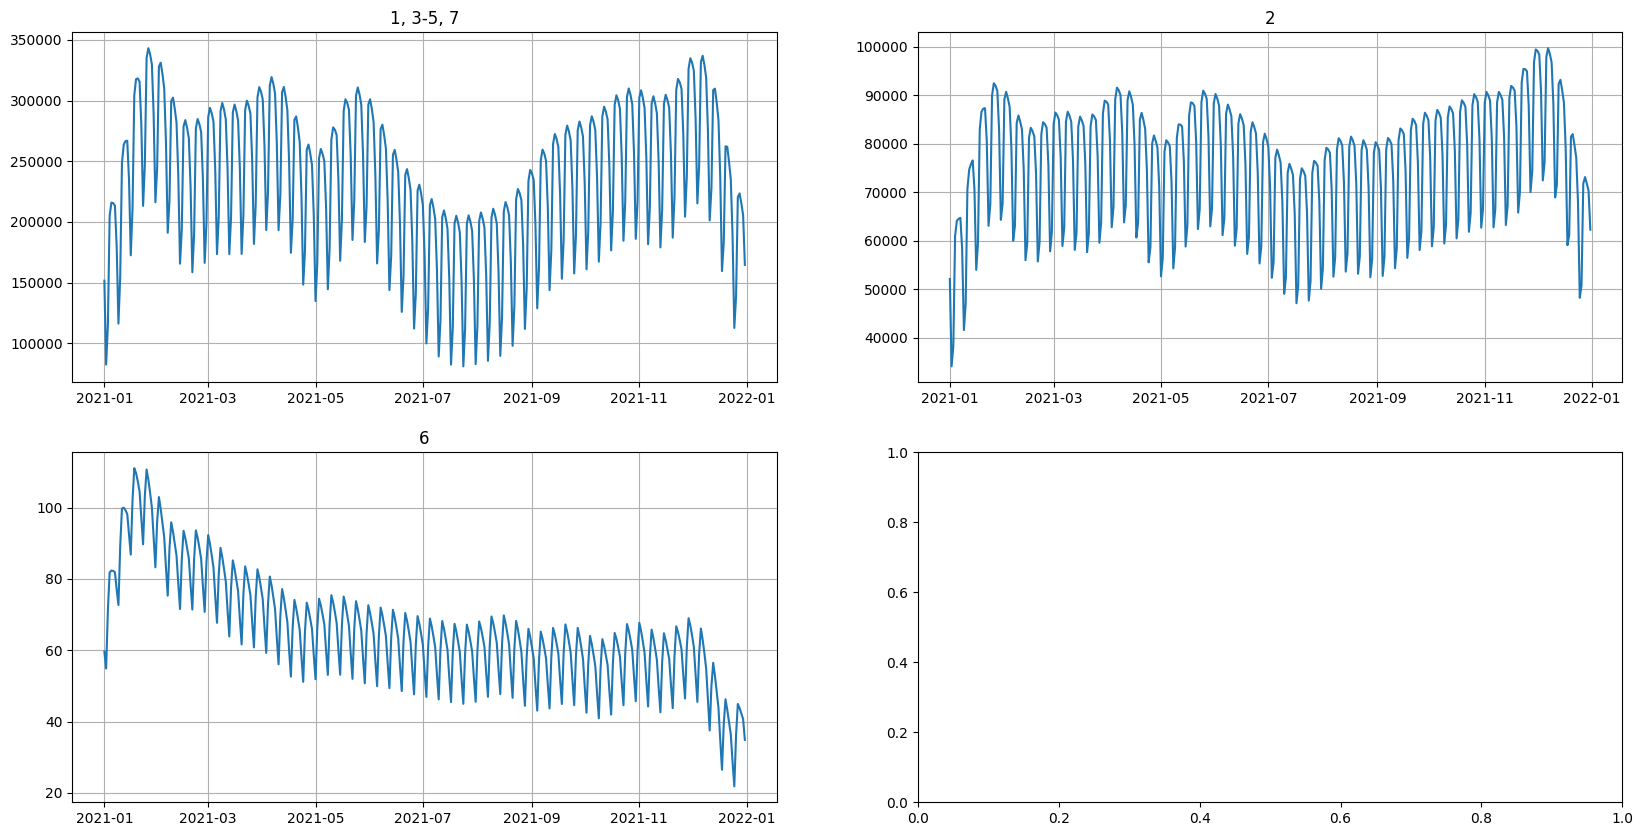

In [ ]:
forecast_ts.plot()

In [ ]:
forecast_df_2 = forecast_ts.to_pandas().reset_index()
forecast_df_2.head()

segment,timestamp,"1, 3-5, 7",2,6
feature,,target,target,target
0,2021-01-01,151553.021677,52100.700873,59.644869
1,2021-01-02,82419.593701,34079.353258,54.876620
2,2021-01-03,115577.700477,38347.645529,71.280924
3,2021-01-04,205094.525835,61007.442334,81.817699
4,2021-01-05,215929.203329,64086.496066,82.339101


In [ ]:
# посчитайте ошибку по данным из test_sum_df

mape2 = mape(test_sum_df.y, forecast_df_2[forecast_df_2.timestamp <= '2021-06-30'].iloc[:, 1:].sum(axis=1))
print(f'mape2 = {mape2}')

mape2 = 14.355225342310804


В итоге ухудшили прогноз. Это очень грустно)

Но возможно подобрав параметры все станет лучше

## 2.3. Улучшение модели (1 балл)

7. Для каждой группы из предыдущего задания постройте графики с фактом (train + test) и прогнозом, визуально оцените качество прогноза
8. Найдите недостатки, очистите временные ряды от аномалий или обновите параметры модели. Учтите праздники, если позволяет модель. Увеличить точность может использование не-статистического метода для какого-либо из рядов
9. Сделайте прогноз и замерьте качество на суммарных поисках, назовите ошибку `mape3`

Задание считается выполненным, если вы получили `mape3 < mape2` и `mape3 < mape1`, а прогноз №3 на весь 2021 год выглядит визуально адекватным

In [ ]:
test_df.ds.max()

Timestamp('2021-06-30 00:00:00')

In [ ]:
# чтобы сравнить каждую группу с тестовой выборкой, нужно так же сгруппировать данные в ней
prep_test_df = pd.DataFrame({'ds': test_df.ds,
                         '1, 3-5, 7': list(pd.concat([train_df['1'], train_df.iloc[:, 3:6], train_df['7']], axis=1).sum(axis=1)),
                         '2':train_df['2'],
                         '6':train_df['6']})

# факт для графиков
train_and_test_df = pd.concat([prep_test_df, prep_train_df])

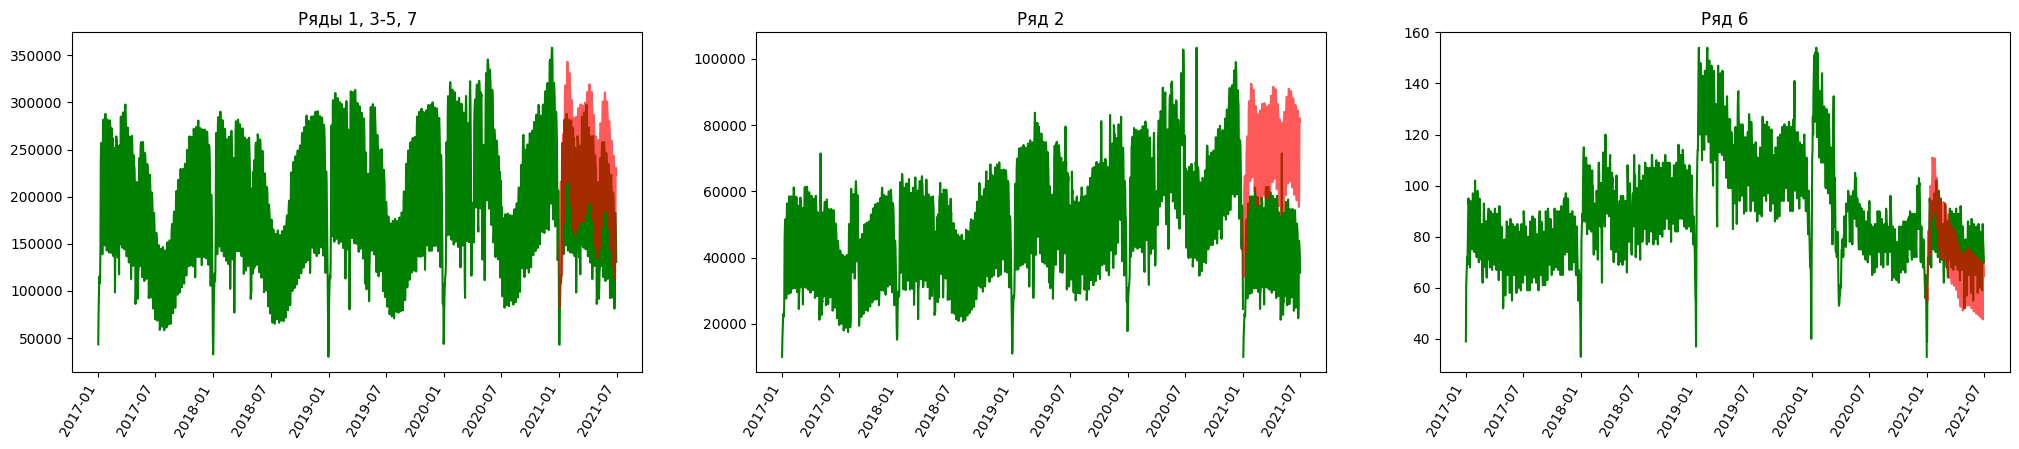

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
fig.autofmt_xdate(rotation=60)

# Creating the sub-plots.
ax1.plot(train_and_test_df.ds, train_and_test_df['1, 3-5, 7'], color='green', label='fact')
ax1.plot(forecast_df_2[forecast_df_2.timestamp <= '2021-06-30'].timestamp, forecast_df_2[forecast_df_2.timestamp <= '2021-06-30']['1, 3-5, 7'], color='red', alpha=0.65, label='predict')
ax1.set_title('Ряды 1, 3-5, 7')

ax2.plot(train_and_test_df.ds, train_and_test_df['2'], color='green', label='fact')
ax2.plot(forecast_df_2[forecast_df_2.timestamp <= '2021-06-30'].timestamp, forecast_df_2[forecast_df_2.timestamp <= '2021-06-30']['2'], color='red', alpha=0.65, label='predict')
ax2.set_title('Ряд 2')

ax3.plot(train_and_test_df.ds, train_and_test_df['6'], color='green', label='fact')
ax3.plot(forecast_df_2[forecast_df_2.timestamp <= '2021-06-30'].timestamp, forecast_df_2[forecast_df_2.timestamp <= '2021-06-30']['6'], color='red', alpha=0.65, label='predict')
ax3.set_title('Ряд 6')

plt.show()

Общая проблема в том, что в 21 году начался ковид и соответсвенно количество запросов по поиску работы упало. Но этот спад не может быть предсказан на основе исторических данных, так как там в основном тренд на рост.

То есть нам надо аналитически установить некоторую верхнюю границу, за который не должен выходить предикт.

Вообще можно обработать скачок как аутлаер. Попробуем это сделать

In [ ]:
from etna.analysis.outliers import (get_anomalies_density, get_anomalies_hist,
                                    get_anomalies_median,
                                    get_anomalies_prediction_interval)

from etna.analysis import plot_anomalies_interactive, plot_anomalies

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbdd_vhmy/5911m_i5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbdd_vhmy/g7ospln3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50192', 'data', 'file=/tmp/tmpbdd_vhmy/5911m_i5.json', 'init=/tmp/tmpbdd_vhmy/g7ospln3.json', 'output', 'file=/tmp/tmpbdd_vhmy/prophet_modelytw4ettu/prophet_model-20230617175145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbd

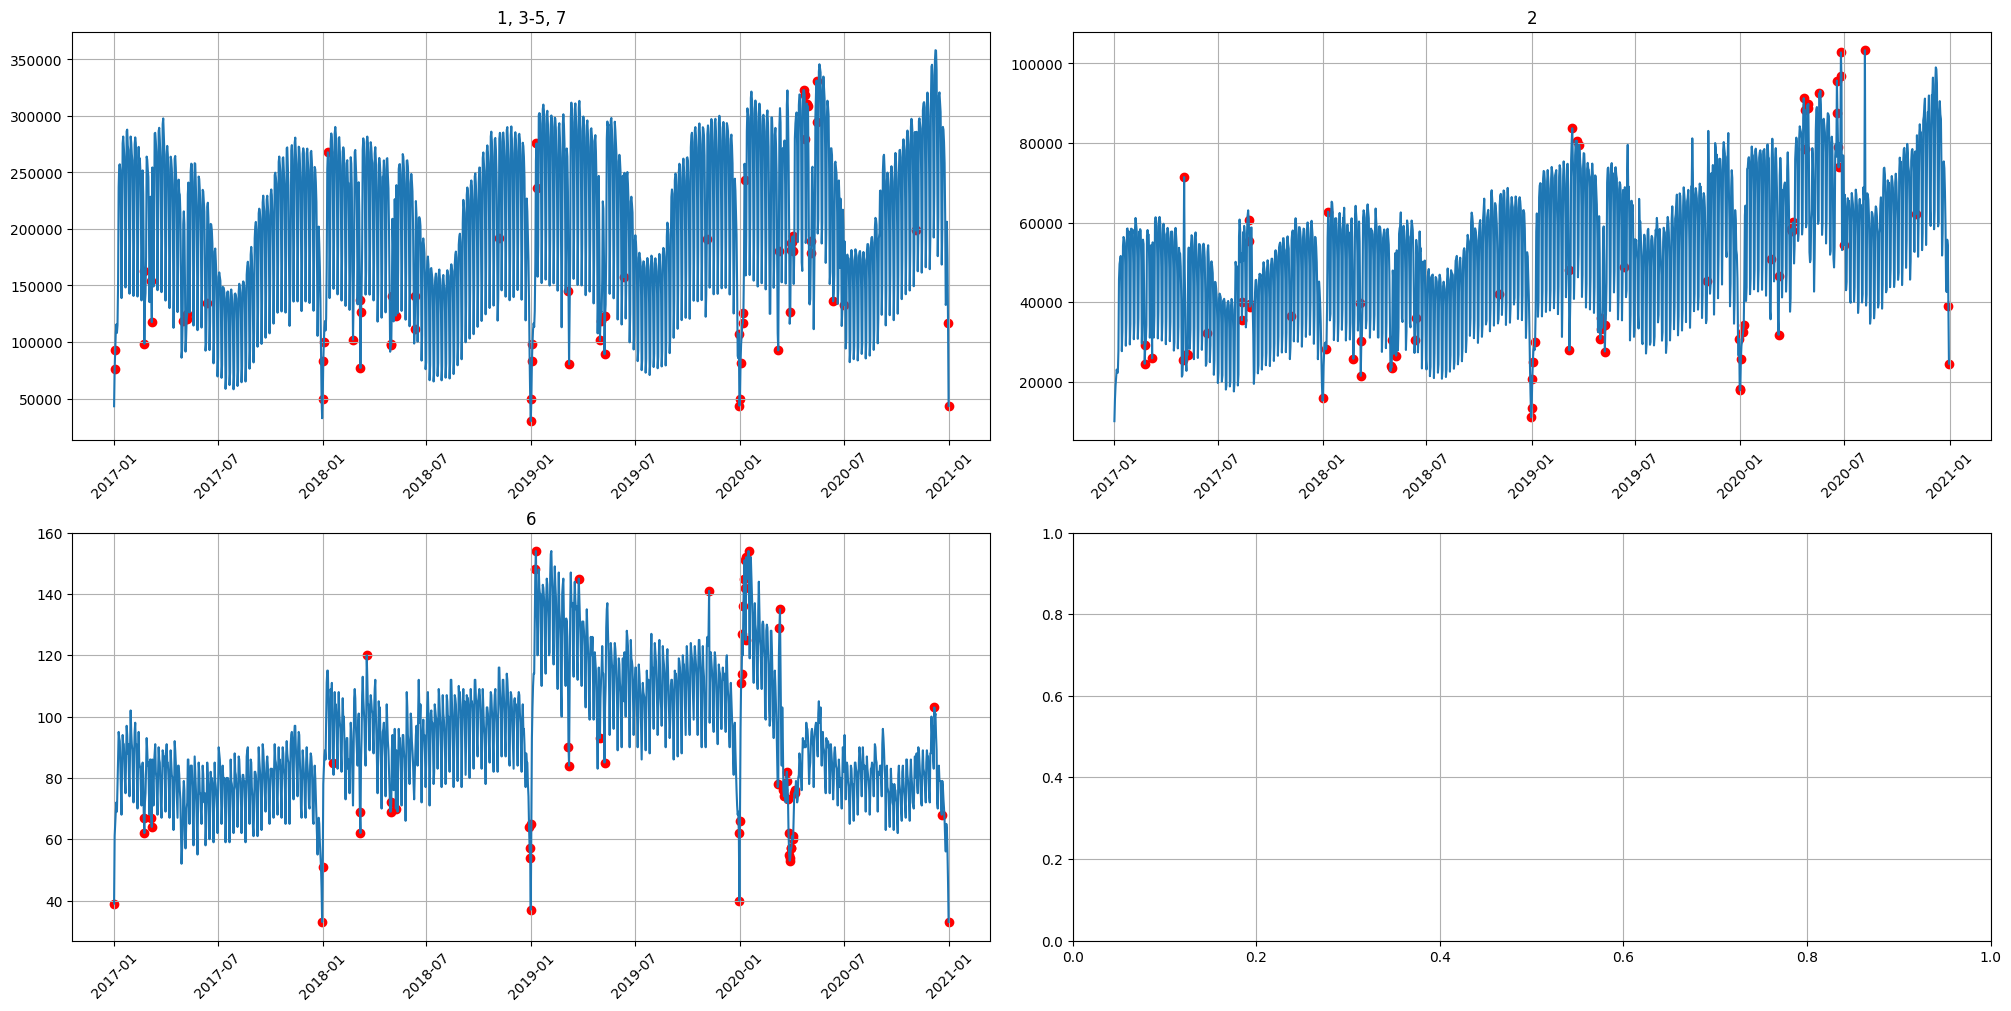

In [ ]:
anomaly_dict = get_anomalies_prediction_interval(
    ts, model=ProphetModel, interval_width=0.97
)

plot_anomalies(ts, anomaly_dict)

Вообще предикт на интервале хорошо идентифицирует выбросы. Часть из них конечно является сезонными и возможно не стоит их убирать, но в целом неплохо.

Попробуем еще поиграться с интерактивной визуализацией с идентификацией аутлаеров через медиану в окне

In [ ]:
method = get_anomalies_median
params_bounds = {
                "window_size": (5, 100, 1),
                 "alpha": (0.1, 4, 0.25)
                 }
plot_anomalies_interactive(
    ts=ts, segment='1, 3-5, 7', method=method, params_bounds=params_bounds
)

interactive(children=(IntSlider(value=5, continuous_update=False, description='window_size', min=5, style=Slid…

У меня не получилось ничего хорошего, поэтому попробуем использовать первый вариант

In [ ]:
from etna.transforms import (DateFlagsTransform, FilterFeaturesTransform,
                              STLTransform,
                             HolidayTransform, LagTransform,
                             LinearTrendTransform, LogTransform, MeanTransform,
                             MedianOutliersTransform, SegmentEncoderTransform,
                             TimeSeriesImputerTransform, PredictionIntervalOutliersTransform)
from etna.pipeline import Pipeline

In [ ]:
import copy
try_ts = copy.deepcopy(ts)

In [ ]:
transforms = [
    LogTransform(in_column="target"), # логарифмируем таргет, чтобы сделать ряд более стационарным (разброс становится равномерным)
    LinearTrendTransform(in_column="target"), # достаем компоненту тренда
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        is_weekend=True,
        out_column="date_flag",
    ),
    HolidayTransform(iso_code="RU", out_column="RU_holidays"),
    PredictionIntervalOutliersTransform(in_column="target", model=ProphetModel, interval_width=0.97)
]

model = ProphetModel()

pipeline = Pipeline(model=model, transforms=transforms, horizon=365)

In [ ]:
pipeline.fit(try_ts)
forecast_ts = pipeline.forecast(try_ts)

/usr/local/lib/python3.10/dist-packages/etna/transforms/decomposition/detrend.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[self.in_column] = no_trend_timeseries
/usr/local/lib/python3.10/dist-packages/etna/transforms/decomposition/detrend.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[self.in_column] = no_trend_timeseries
/usr/local/lib/python3.10/dist-packages/etna/transforms/decomposition/detrend.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [ ]:
# постройте прогноз по очищенным категориям запросов

forecast_df_3 = forecast_ts.to_pandas().reset_index()

In [ ]:
# посчитайте ошибку по данным из test_sum_df

mape3 = mape(test_sum_df.y, forecast_df_3[forecast_df_3.timestamp <= '2021-06-30'][[['1, 3-5, 7', 'target'], ['2', 'target'], ['6', 'target']]].sum(axis=1))
print(f'mape3 = {mape3}')

mape3 = 12.85710901059295


Стало не прям чтобы сильно лучше, но глобально задание выполнено.

Не хватает понимание, как учесть в модели то, что мы ожидаем понижения, но на данных этого не видно. Возможно, стоит добавить какие-то внешние факторы

## 2.4 Валидация модели (1 балл)

Вы обучали модель на обучающей выборке (train) и корректировали модель, основываясь на ошибке на тестовой выборке (test). Если при этом не оценивать прогноз визуально, модель может "[переобучиться](https://neerc.ifmo.ru/wiki/index.php?title=Переобучение)". В этом случае она будет хорошо предсказывать первое полугодие 2021, а другие периоды - плохо.

Давайте проверим, смогла ли модель понять общие зависимости в данных или переобучилась. Для этого нужно посчитать ошибку на `val.csv` (2021-06-01 - 2021-12-31) для всех моделей.

Задание считается выполненным, если корректно посчитана ошибка на валидационной выборке и построен итоговый график с фактом и прогнозами.

In [ ]:
val_df = pd.read_csv('val.csv', parse_dates=['ds'])
val_df.head()

,ds,1,2,3,4,5,6,7,8
0,2021-07-01,62766,58049,31976,27163,18777,79,42951,0
1,2021-07-02,54381,53112,28523,21717,17004,69,35499,0
2,2021-07-03,34160,36569,24154,11258,9027,67,9524,0
3,2021-07-04,36378,38771,28183,13988,9564,79,10200,0
4,2021-07-05,58207,59820,33812,22573,17787,86,40220,0


In [ ]:
# сумма всех рядов
val_sum_df = pd.DataFrame({'ds': val_df.ds, 'y': list(val_df.iloc[:, 1:].sum(axis=1))})
val_sum_df.head()

,ds,y
0,2021-07-01,241761
1,2021-07-02,210305
2,2021-07-03,124759
3,2021-07-04,137163
4,2021-07-05,232505


In [ ]:
# посчитайте ошибку на второе полугодие 2021 года для всех прогнозов

val_error_1 = mape(val_sum_df.y, forecast_df_1[forecast_df_1.ds <= '2021-06-30'].yhat)   # изначальный прогноз суммы
val_error_2 = mape(val_sum_df.y, forecast_df_2[forecast_df_2.timestamp > '2021-06-30'].iloc[:, 1:].sum(axis=1))  # прогноз, разбитый на подкатегории
val_error_3 = mape(val_sum_df.y, forecast_df_3[forecast_df_3.timestamp > '2021-06-30'][[['1, 3-5, 7', 'target'], ['2', 'target'], ['6', 'target']]].sum(axis=1))   # прогноз, разбитый на подкатегории и очищенный от аномалий

In [ ]:
val_error_1

38.86095551457327

In [ ]:
val_error_2

15.38908525726748

In [ ]:
val_error_3

12.323229757251164

Обычно ошибка на валидационной выборке больше, чем на тестовой, это нормально. Однако, если она **гораздо** (например, в разы) больше ошибки на тестовой выборке, модель переобучилась.

Если ошибка получилась большой, это не критично: у нас не было цели создать идеальный прогноз. Основными критериями при оценивании домашнего задания будут методологически верный подход к построению и визуальная адекватность полученного прогноза

In [ ]:
full_df = pd.concat([train_sum_df, test_sum_df, val_sum_df])
full_df.max()

ds    2021-12-31 00:00:00
y                  507600
dtype: object

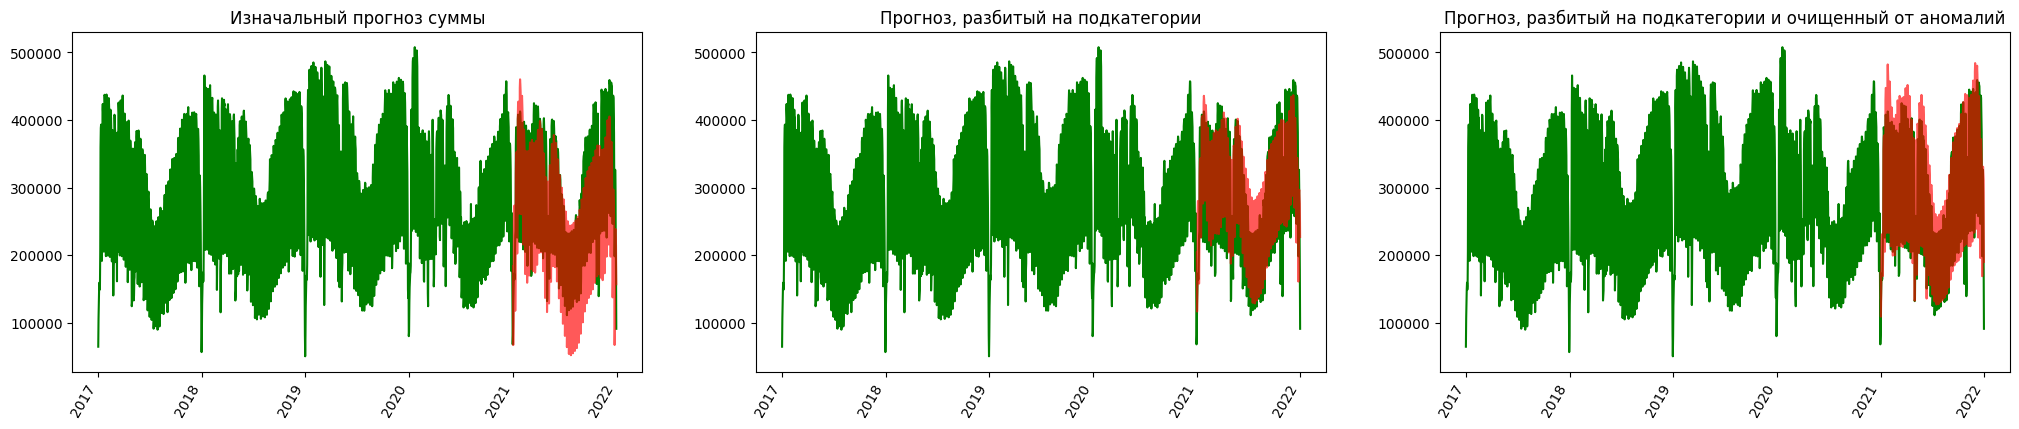

In [ ]:
# постройте при приложите график суммы поисков с фактом (train + test + val) и всеми прогнозами
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
fig.autofmt_xdate(rotation=60)

# Creating the sub-plots.
ax1.plot(full_df.ds, full_df.y, color='green', label='fact')
ax1.plot(forecast_df_1.ds, forecast_df_1.yhat, color='red', alpha=0.65, label='predict')
ax1.set_title('Изначальный прогноз суммы')

ax2.plot(full_df.ds, full_df.y, color='green', label='fact')
ax2.plot(forecast_df_2.timestamp, forecast_df_2.iloc[:, 1:].sum(axis=1), color='red', alpha=0.65, label='predict')
ax2.set_title('Прогноз, разбитый на подкатегории')

ax3.plot(full_df.ds, full_df.y, color='green', label='fact')
ax3.plot(forecast_df_3.timestamp, forecast_df_3[[['1, 3-5, 7', 'target'], ['2', 'target'], ['6', 'target']]].sum(axis=1), color='red', alpha=0.65, label='predict')
ax3.set_title('Прогноз, разбитый на подкатегории и очищенный от аномалий')

plt.show()

урааааа! Реально хороший прогноз. Очень горжусь собой, хотя еще многое можно было бы усовершенствовать :)